<a href="https://colab.research.google.com/github/Sylvia53/tibame1224/blob/main/%E5%9C%98%E5%B0%88_%E8%A8%93%E7%B7%B40308.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第九組團隊專題

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
#載入訓練用資料
import pandas as pd
import numpy as np
data = pd.read_csv('/content/drive/MyDrive/團專檔案/汽車保險理賠預測/train.csv')
data.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


In [39]:
#列出欄位名稱
data.columns

Index(['policy_id', 'policy_tenure', 'age_of_car', 'age_of_policyholder',
       'area_cluster', 'population_density', 'make', 'segment', 'model',
       'fuel_type', 'max_torque', 'max_power', 'engine_type', 'airbags',
       'is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
       'is_parking_camera', 'rear_brakes_type', 'displacement', 'cylinder',
       'transmission_type', 'gear_box', 'steering_type', 'turning_radius',
       'length', 'width', 'height', 'gross_weight', 'is_front_fog_lights',
       'is_rear_window_wiper', 'is_rear_window_washer',
       'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
       'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert', 'ncap_rating', 'is_claim'],
      dtype='object')

In [40]:
# 刪除 price為空值的資料列
data = data.dropna(subset=['is_claim'])

# 自動前處理 (自製)

In [41]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
class AutoPreprocess:
    def __init__(self):
        self.scaler = {}
        self.fillna_value = {}
        self.onehotencode_value = {}
        self.field_names = []
        self.final_field_names = []

    def fit(self, data, field_names):
        self.__init__()
        self.field_names = field_names

        for fname in field_names:
            #自動補空值
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
                # self.fillna_value[fname] = 'np.nan'
                # self.fillna_value[fname] = np.nan # 維持空值
            elif data[fname].dtype == bool: #布林型態
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
            else: # 數字型態
                self.fillna_value[fname] = data[fname].median()  #補中位數

            #自動尺度轉換(scaling)
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                pass #不用轉換
            elif data[fname].dtype == bool: #布林型態
                pass #不用轉換
            else: # 數字型態
                vc = data[fname].value_counts()
                if data[fname].isin([0, 1]).all(): #當數值只有0跟1
                    pass #不用轉換
                elif pd.api.types.is_integer_dtype(data[fname]) and data[fname].nunique() <= 10: #是否簡單的整數型類別且數量小於10
                    self.scaler[fname] = MinMaxScaler()
                    self.scaler[fname].fit(data[[fname]])
                else: #其他的數字型態
                    self.scaler[fname] = StandardScaler()
                    self.scaler[fname].fit(data[[fname]])


            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                field_value = data[fname].value_counts().index
                self.onehotencode_value[fname] = field_value
                for value in field_value:
                    fn = fname+"_"+value
                    # data[fn] = (data[fname] == value).astype('int8')
                    self.final_field_names.append(fn)
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                # data[fname] = data[fname].astype(int)
                self.final_field_names.append(fname)
            else: # 數字型態 不用重新編碼
                self.final_field_names.append(fname)

        return

    def transform(self, data):
        #如果輸入的data是dict，要先轉成dataframe
        if isinstance(data, dict):
            for fname in self.field_names:
                if fname in data:
                    data[fname] = [data[fname]]
                else:
                    data[fname] = [np.nan]
            data = pd.DataFrame(data)
        else: #將資料複製一份，不修改原本的資料
            data = data.copy()

        for fname in self.field_names:
            #自動補空值
            if data[fname].isnull().any(): #有空值
                # if fname in self.fillna_value:
                    data[fname] = data[fname].fillna(self.fillna_value[fname])


            #自動尺度轉換(scaling)
            if fname in self.scaler:
                data[fname] = self.scaler[fname].transform(data[[fname]])

            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                if fname in self.onehotencode_value:
                    field_value = self.onehotencode_value[fname]
                for value in field_value:
                    fn = fname+"_"+value
                    data[fn] = (data[fname] == value).astype('int8')
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                data[fname] = data[fname].astype(int)
            else: # 數字型態 不用重新編碼
                pass
        return data[self.final_field_names]

    def save(self, file_name):
        with open(file_name, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(file_name):
        with open(file_name, "rb") as f:
            return pickle.load(f)

In [20]:
# # AutoPreprocess Example
# ####################################################
# # Train Step
# mydata = pd.read_csv('../data/Automobile_Train.csv')
# ap = AutoPreprocess()
# ap.fit(mydata, ['symboling', 'Normalized-losses', 'make', 'Fuel-type', 'aspiration',
#        'Num-of-doors', 'Body-style', 'Drive-wheels', 'Engine-location',
#        'Wheel-base', 'length', 'width', 'height', 'Curb-weight', 'Engine-type',
#        'Num-of-cylinders', 'Engine-size', 'Fuel-system', 'bore', 'stroke',
#        'Compression-ratio', 'horsepower', 'Peak-rpm', 'City-mpg',
#        'Highway-mpg'])
# ap.save("C:/DATA/test.bin")

# ####################################################
# # Test and inference
# ap2 = AutoPreprocess.load("C:/DATA/test.bin")
# d2 = ap2.transform(mydata) #Pandas Dataframe
# d2.head()

# ####################################################
# # Test and inference with one record
# ap2 = AutoPreprocess.load("C:/DATA/test.bin")
# data_dict = {"symboling":1, "aspiration":"std"}
# d2 = ap2.transform(data_dict) #Python Dict
# print(d2)


# 前處理

In [42]:
ap = AutoPreprocess()
ap.fit(data, ['policy_tenure', 'age_of_car', 'age_of_policyholder',
       'area_cluster', 'population_density'])
ap.save('/content/drive/MyDrive/團專檔案/汽車保險理賠預測/train.csv')

X = ap.transform(data)
y = data['is_claim']

# 訓練模型 : 方法一

In [47]:
from sklearn.model_selection import train_test_split
# 分割資料成訓練組跟驗證組
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

In [49]:
# 訓練模型
# from sklearn.neural_network import MLPRegressor
# model = MLPRegressor(hidden_layer_sizes=(200,), max_iter=200, random_state=42)

# from sklearn.tree import DecisionTreeRegressor
# model = DecisionTreeRegressor()

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=130,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced_subsample",  # 自動平衡權重
    random_state=42
)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=130, random_state=42)

訓練組 : 0.795747053557307
驗證組 : 0.795747053557307


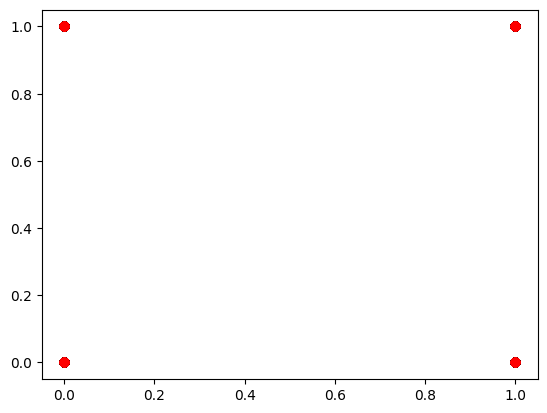

In [50]:
# 驗證模型
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score#r2_score
y_pred = model.predict(X_train)
auc = roc_auc_score(y_train, y_pred)
print("訓練組 :", auc)
plt.scatter(y_train, y_pred, alpha=0.6, color='b')
# plt.show()

y_pred = model.predict(X_train)
auc = roc_auc_score(y_train, y_pred)
print("驗證組 :", auc)
plt.scatter(y_train, y_pred, alpha=0.6, color='r')
plt.show()


In [52]:
#儲存模型
import pickle

with open("/content/drive/MyDrive/團專檔案/汽車保險理賠預測/model.bin", "wb") as f:
    pickle.dump(model, f)
